In [1]:
import requests, time, calendar, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Summary of this work

- Practice data analysis tool set (Python, Pandas, matplotlib, etc).

- data collecting and processing, using web scrapping (data from 1-1-19 to 30-9-19).

- feature engineering with DataFrame, Time Series using Pandas.

- Conditional Probability Calculation (Bayesian Analysis).


### Key Findings: 

- **3%** of tracks (the Top 40) contributs **29%** of total streams (or market share)

- only **13%** of tracks (based on lifespan data) can stay on the charts for more than **6 weeks**.

- If a new track hit Top 10 on the first day (release day), it has 35% chance to be the Top 40 of the year.


## 1 - Scrape track data from *_www.spotifycharts.com_*
> ***Skip Section Web Scraping (if data is available at ".Glabal_Daily_2019.csv")***

scrape raw data from webpage and clean the data into Python list format
-    1. scrape the raw data using requests library
-    2. extract the track info only into a list
-    3. merge all into one list when iterating through the dates

In [2]:
# # prepare the related parameters for web scrapping
# url = 'https://spotifycharts.com/regional/global/daily/date/download'

# start_date = '2019-01-01' # required format %Y-%m-%d
# end_date = '2019-09-30'
# date_rng = [x.strftime('%Y-%m-%d') for x in pd.date_range(start=start_date, end=end_date)]

In [3]:
# data = [] # list for cleaned data
# headers = {"user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1 Safari/605.1.15"}

# for date in date_rng:
#     response = requests.get(url.replace('date', date), headers=headers)
#     # raw text in csv format
#     time.sleep(0.2) # lower scrapping freq
    
#     raw = response.text.splitlines()[2:] # remove irrelevant data
#     raw = [x for x in csv.reader(raw)] # reformat into list with csv reader
#     raw = [[date] + x for x in raw] # add date info into the list
    
#     data += raw # merge the raw data into the data list
    
# print('Top 200 Spotify Charts up to date of {end_date}, in total {len(data)} lines data scraped.')

Top 200 Spotify Charts up to date of 2019-09-30, in total 54600 lines data scraped.


In [4]:
# # Data to be loaded as Pandas DataFrame for data analysis
# headers = ['Date', 'Position', 'Track Name', 'Artist', 'Streams', 'URL']
# df = pd.DataFrame(data, columns=headers)
# df = df.astype({'Date':'datetime64[D]', 'Position':'int32', 'Streams':'int32'})
# df.shape

(54600, 6)

In [2]:
df = pd.read_csv('Global_Daily_2019.csv')
df.head()

,Date,Position,Track Name,Artist,Streams,URL
0,2019-01-01,1,"thank u, next",Ariana Grande,3978028,https://open.spotify.com/track/2rPE9A1vEgShuZx...
1,2019-01-01,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,3883836,https://open.spotify.com/track/3KkXRkHbMCARz0a...
2,2019-01-01,3,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",DJ Snake,3351784,https://open.spotify.com/track/4w8niZpiMy6qz1m...
3,2019-01-01,4,Wow.,Post Malone,3195966,https://open.spotify.com/track/6MWtB6iiXyIwun0...
4,2019-01-01,5,MIA (feat. Drake),Bad Bunny,2777884,https://open.spotify.com/track/116H0KvKr2Zl4RP...


In [3]:
df.Date = df.Date.astype('datetime64[D]')
df.dtypes

Date          datetime64[ns]
Position               int64
Track Name            object
Artist                object
Streams                int64
URL                   object
dtype: object

## 2 - Data Exploring of Spotify daily charts

   - Reach min **half million** daily streams to get on the charts
   
   - Daily streams increase as an exponential funtion of daily ranking
   
   - A **weekly periodic cycle** observed in total streams, as **Friday hits the peak** and Sun for bottom.

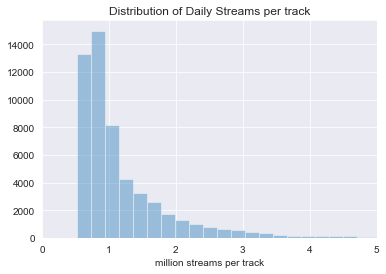

In [4]:
# daily streams distribution
sns.set_style(style='darkgrid')
sns.distplot(df['Streams']/1000000, hist=True, kde=False, axlabel='million streams per track')
plt.title('Distribution of Daily Streams per track')
plt.xlim(0, 5)
plt.show()

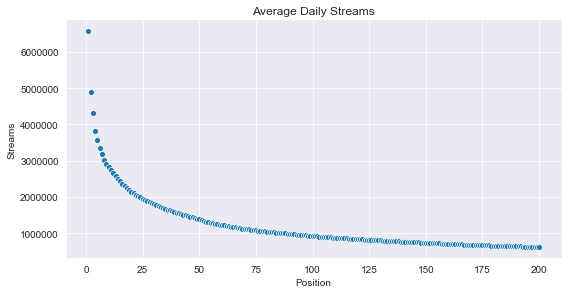

In [5]:
df_position = df.groupby('Position').mean().reset_index()
sns.relplot(x='Position', y='Streams', data=df_position, kind='scatter', height=4, aspect=2)
plt.title('Average Daily Streams')
plt.show()

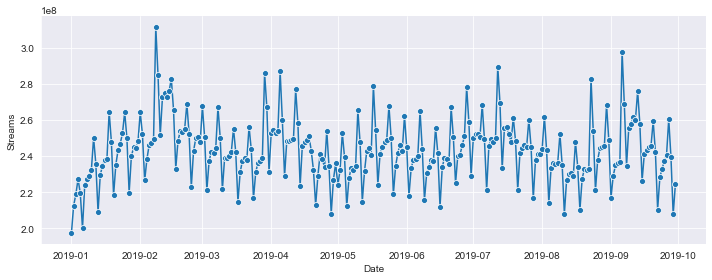

In [6]:
# total streams of each day show a periodic chart
df_dailytotal = df.groupby('Date').sum()
sns.relplot(x='Date', y='Streams', data=df_dailytotal.reset_index(), kind='line', marker='o', height=4, aspect=2.5)
plt.show()

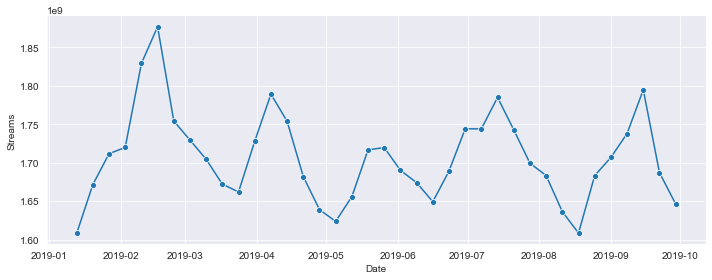

In [7]:
# Weekly total streams cross the year, no obvious seasonal cycles observed
sns.relplot(x='Date', y='Streams', data=df_dailytotal.resample('W').sum().reset_index().iloc[1:-1], kind='line', marker='o', height=4, aspect=2.5)
plt.show()

### 3 - Lifespan of each track on charts
> to get a complete lifespan, tracks were selected only if they appeared on charts since 2019 and got off chart before enddate of the dataset.

   - In total **826** new tracks appeared on and off charts in 2019 up to date.
   - More than half were off the charts within **one week**.
   - Only **13%** of the tracks showed a lifespan on chart greater than **6 weeks**.

In [8]:
df_lifespan = df.groupby(['Track Name','Artist']).filter(
    lambda x: (x['Date'].min() > df['Date'].min()) & (x['Date'].max() < df['Date'].max()))

In [9]:
# in total 826 tracks analyzed
df_lifespan_weeks = df_lifespan.groupby(['Track Name', 'Artist']).count().Date.reset_index()
df_lifespan_weeks['Weeks'] = np.ceil(df_lifespan_weeks.Date/7).astype('int') # lifespan in weeks
df_lifespan_weeks.tail()

,Track Name,Artist,Date,Weeks
821,weR mAChT PaRA 2,Dardan,4,1
822,when the party's over - Recorded at Spotify St...,Lewis Capaldi,8,2
823,xanny,Billie Eilish,83,12
824,you should see me in a crown,Billie Eilish,148,22
825,È sempre bello,Coez,1,1


In [10]:
# Present findings in a pie chart

df_lifespan_weeks_counts = df_lifespan_weeks.groupby('Weeks').count().Date # count weeks
data = df_lifespan_weeks_counts[:6].to_list() # add counts of 1 week to 6 weeks
data.append(df_lifespan_weeks_counts[6:].sum()) # add counts of more than 6 weeks
# prepare pie chart legend
legend = df_lifespan_weeks_counts[:6].index.to_list() 
legend = ['1 Week'] + [str(x)+' Weeks' for x in legend[1:]]
legend.append('> 6 weeks')

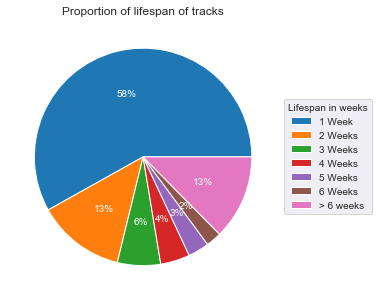

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.pie(data, autopct='%1.f%%', textprops=dict(color="w"), startangle=0)
ax.legend(legend, title="Lifespan in weeks", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title("Proportion of lifespan of tracks")
plt.show()

##  4 - Top 40 Chellenge (Bayesian analysis)

The income of an music artist depends on the total streams of his/her tracks on Spotify.
There are thousands of new tracks coming up in the year, **how difficult is it to hit the Top 40**?

   - The Top 40 is only **3%** of the total tracks of the year.
   
   - The Top 40 (3% tracks) come from **7%** of the artists.
   
   - The Top 40 (3% tracks) contribute **29%** total streams(market share).

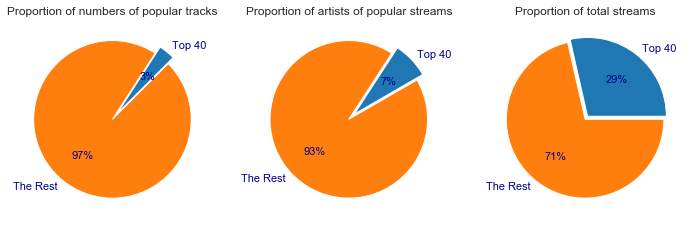

In [12]:
# sum up daily streams for total streams analysis
df_total_streams = df.groupby(['Track Name', 'Artist']).sum().sort_values('Streams', ascending=False)
Total_Tracks = df_total_streams.shape[0] # counts of total tracks
Total_Streams = df_total_streams['Streams'].sum() # number of total streams
Top40_Tracks = 40
Top40_Streams = df_total_streams.head(40)['Streams'].sum() # total streams of top40
Total_Artist = df_total_streams.reset_index().groupby('Artist').sum().shape[0] # counts of artists
Top40_Artist = df_total_streams.head(40).reset_index().groupby('Artist').sum().shape[0] 

fig, ax = plt.subplots(1, 3, figsize=(12,4), subplot_kw=dict(aspect="equal"), sharey=True)
textprops = {'size': 11, 'color': 'darkblue', 'weight': 'regular'}
ax[0].pie([Top40_Tracks, Total_Tracks-Top40_Tracks], labels=['Top 40', 'The Rest'], explode=[0.1, 0], autopct='%1.0f%%', startangle=45, textprops=textprops)
ax[1].pie([Top40_Artist, Total_Artist-Top40_Artist], labels=['Top 40', 'The Rest'], explode=[0.1, 0], autopct='%1.0f%%', startangle=30, textprops=textprops)
ax[2].pie([Top40_Streams, Total_Streams-Top40_Streams], labels=['Top 40', 'The Rest'], explode=[0.05, 0], autopct='%1.0f%%', startangle=0, textprops=textprops)
ax[0].set_title('Proportion of numbers of popular tracks')
ax[1].set_title('Proportion of artists of popular streams')
ax[2].set_title('Proportion of total streams')
plt.show()

###  Bayesian Analysis
#### The importance of the popularity of the first day on Spotify Chart

>*Question*: what is the probability that a new track is one of the Top 40 of the year, **if it hits top 10 on the first day**?


$$ P(A|B) = \frac{P(B|A) \times P(A)}{P(B)} $$

    * A: a single track is in Top 40 of the year (according to total streams up to date)
    * B: a single track is in Top 10 the 1st day on Spotify Chart (according to the daily streams of the day)

In [14]:
# select new arrival tracks in 2019 and also stays on charts over 30 days
df_new_2019 = df.groupby(['Track Name','Artist']).filter(
        lambda x: (x['Date'].min() > pd.Timestamp('2019-1-1')) & (len(x) > 30))

In [15]:
# count how many new arrival track in the dataset
df_new_2019.groupby('Track Name').nunique().count()

Date          253
Position      253
Track Name    253
Artist        253
Streams       253
URL           253
dtype: int64

In [16]:
# collect the data of new tracks on the first day on Spotify Chart
df_new_day1 = df_new_2019.groupby(['Track Name', 'Artist']).min().Date.to_frame().reset_index()
df_new_day1 = pd.merge(df_new_day1, df_new_2019, how='inner', on=['Track Name', 'Artist', 'Date'])
df_new_day1.tail() # In total there were 253 new tracks

,Track Name,Artist,Date,Position,Streams,URL
248,needy,Ariana Grande,2019-02-08,3,5821541,https://open.spotify.com/track/1TEL6MlSSVLSdhO...
249,ocean eyes,Billie Eilish,2019-01-02,146,642273,https://open.spotify.com/track/2uIX8YMNjGMD744...
250,wish you were gay,Billie Eilish,2019-03-04,71,1097111,https://open.spotify.com/track/4txc3txsIt81diM...
251,xanny,Billie Eilish,2019-03-29,7,3829019,https://open.spotify.com/track/4QIo4oxwzzafcBW...
252,you should see me in a crown,Billie Eilish,2019-02-03,199,570228,https://open.spotify.com/track/6vsV4D8BM6PioRr...


In [17]:
# 23 new tracks managed to get in the Top 40 of the total streams
df_new_day1[df_new_day1['Track Name'].isin(df_total_streams.head(40).reset_index(level=1).index)].count()

Track Name    23
Artist        23
Date          23
Position      23
Streams       23
URL           23
dtype: int64

In [18]:
df_new_day1[df_new_day1['Position'] < 11].count() # 38 new tracks hit top 10 on the 1st day

Track Name    38
Artist        38
Date          38
Position      38
Streams       38
URL           38
dtype: int64

### Bayesian Analysis Result
- Population: 253 (There were 253 new tracks on the chart since 2019)
- A: 23 (23 of new tracks hit top 40 of total streams up to date)
- B: 38 (38 of new tracks hit top 10 on the first day)


$$ P(B|A) = 23 \div 40 \times 100 % = 57.50\% $$
$$ P(A) = 23 \div 253 \times 100 % = 9.10\% $$
$$ P(B) = 38 \div 253 \times 100 % = 15.02\% $$


Therefore, we could answer the questions we asked earlier:

$$ P(A|B) = \frac{P(B|A) \times P(A)}{P(B)} = \frac{57.5\% \times 9.10\%}{15.02\%} = 34.84\% $$

If a new track hits Top 10 on the release day (the first day), there are approx. 35% chance to be one the Top 40 tracks of the year.